In [2]:
%matplotlib inline

In [4]:
!pip install gymnasium==1.0.0
# !wget https://raw.githubusercontent.com/laktionov/RL-course/refs/heads/2025/hw2/agent_utils.py
# !wget https://raw.githubusercontent.com/laktionov/RL-course/refs/heads/2025/hw2/visualisation_utils.py


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip



# HW2: Случай в казино


**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - Stick (0): the player takes no more cards
 - Hit (1): the player will be given another card, however the player could get over 21 and bust





## Imports and Environment Setup




In [15]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym
import pandas as pd

## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




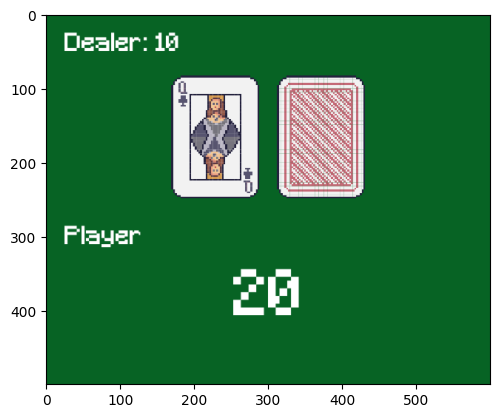

In [11]:
# reset the environment to get the first observation
env = gym.make("Blackjack-v1", sab=True, render_mode="rgb_array")
state, _ = env.reset()

plt.imshow(env.render())

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Task 0: Create and train Q-learning agent (0 point)


In [3]:
%load_ext autoreload
%autoreload 2

In [10]:
from src.qlearning import Agent, QLearningAgent, StateType
from agent_utils import train_agent

import pandas as pd
from tqdm import tqdm

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




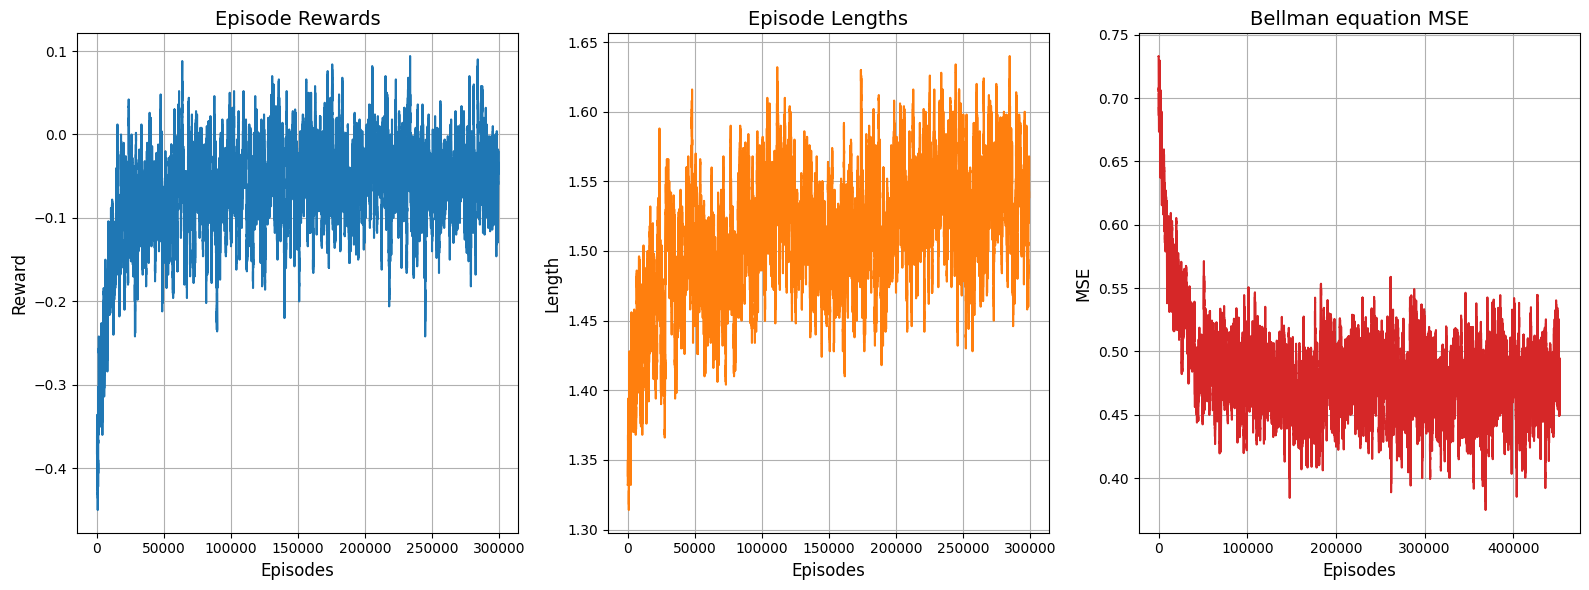

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [00:57<00:00, 5222.47it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [16]:
from agent_utils import train_agent

n_episodes = 300_000
learning_rate = 4e-3
n_actions = env.action_space.n
epsilon = 1.0

env = gym.make("Blackjack-v1", sab=True)
q_learning_agent = QLearningAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
)
train_agent(q_learning_agent, env, n_episodes, epsilon_decay=0.9)

# Task 1: Implement Sarsa($\lambda$) (up to 1 point)

### 1.1 Eligibility Traces

Eligibility traces are a mechanism to bridge between TD(0) methods and Monte-Carlo methods. They "trace" the states (and actions) visited recently, decaying over time, allowing updates to propagate backwards quickly.

### 1.2. Sarsa($\lambda$)

Sarsa($\lambda$) is an **on-policy** method that uses eligibility traces $e(s, a)$

Initialise $Q(s, a)$

Initialise $e(s, a)$ with zeros on each episode start

1. Sample $a_t \sim \mu(.|s_t)$, where $\mu(.|s_t)$ is $\epsilon$-greedy policy w.r.t. current approximation of $Q$.
2. Observe $r_t$ and $s_{t+1}$
3. Calculate $ \delta_t = r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t),$
4. $ e(s_t, a_t) \leftarrow e(s_t, a_t) + 1 $
5. For **all** state-action pairs $(s, a)$:
   * $Q(s,a) \leftarrow Q(s,a) + \alpha \delta_t \cdot e(s,a)$

   * $e(s,a) \leftarrow \gamma \lambda \cdot e(s,a)$

Sarsa($\lambda$) uses the **action taken** by the current policy (often $\epsilon$-greedy w.r.t. $Q$) for the bootstrap term.

In [18]:
from src.qlearning import SarsaAgent

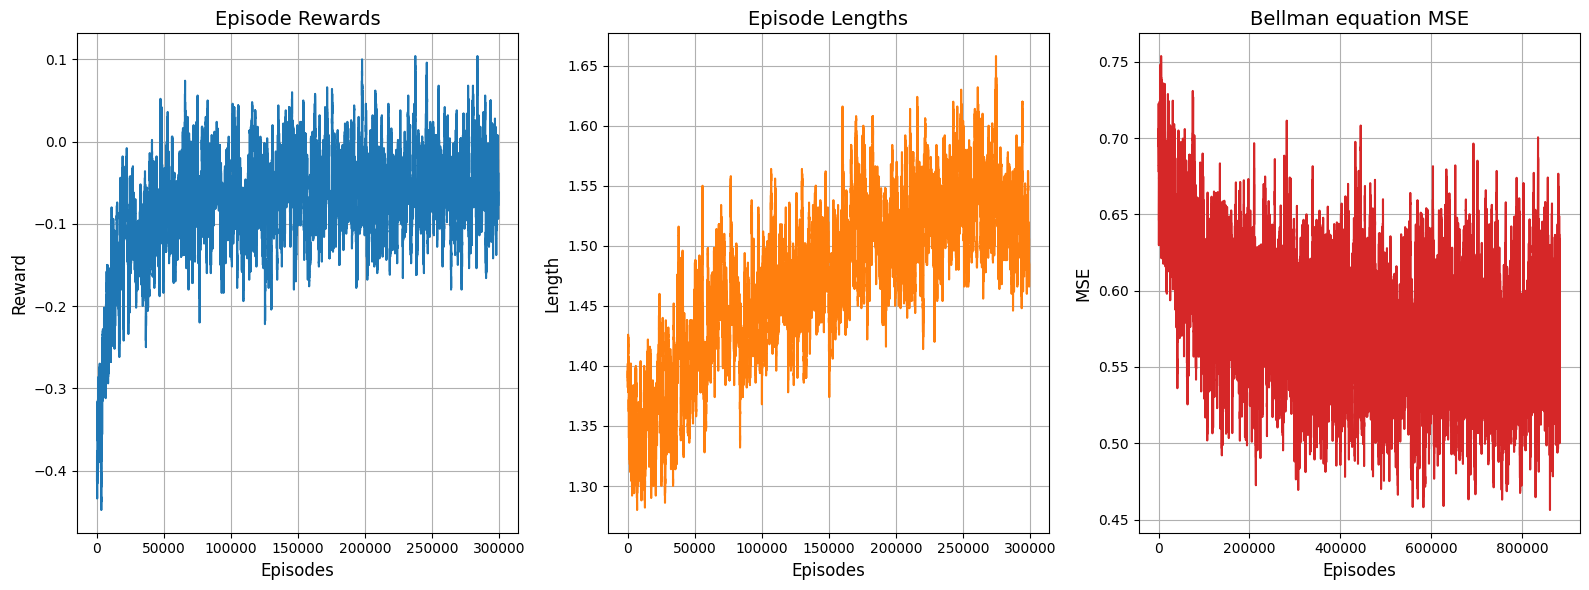

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [01:06<00:00, 4528.48it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [20]:
n_episodes = 300_000
learning_rate = 4e-3
n_actions = env.action_space.n
epsilon = 1.0

env = gym.make("Blackjack-v1", sab=True)
sarsa_agent = SarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0.9,
)
train_agent(sarsa_agent, env, n_episodes, epsilon_decay=0.9)

# Task 2: Implement Expected Value Sarsa($\lambda$) (up to 0.5 point)



In [17]:
from src.qlearning import EVSarsaAgent

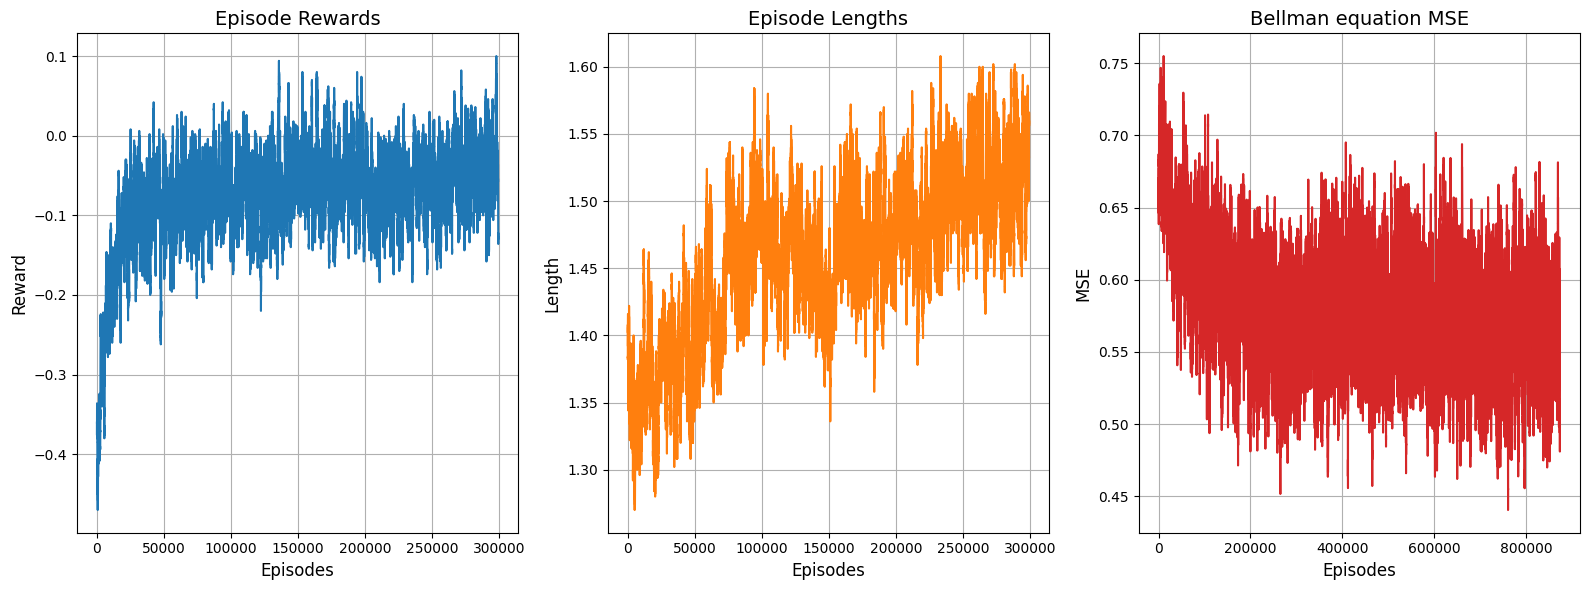

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [01:11<00:00, 4207.89it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [22]:
env = gym.make("Blackjack-v1", sab=True)
expected_sarsa_agent = EVSarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0.9,
)

train_agent(expected_sarsa_agent, env, n_episodes, epsilon_decay=0.9)

# Task 3: Analysis (up to 0.5 point)

In [9]:
from visualisation_utils import visualise_strategy
from agent_utils import evaluate_agent


Write a brief report on your experiments. You may want to train several agents with different hyperparameters.

* Use `visualise_strategy` and `evaluate_agent` to support your conclusions.
* Compare the agents' strategies and evaluation performance with default parameters (Q-learning vs Sarsa(0.9) vs EVSarsa(0.9)).
* Compare the agents' strategies and evaluation performance with $\lambda = 0$ (Q-learning vs Sarsa(0) vs EVSarsa(0)). Why don't we use N-step targets or eligibility traces for Q-learning?
* Compare Sarsa($\lambda$) for different $\lambda$ values.
* Draw any conclusions you find relevant.

###  Compare the agents' strategies and evaluation performance with default parameters (Q-learning vs Sarsa(0.9) vs EVSarsa(0.9)).

In [47]:
import pandas as pd

results = pd.DataFrame({'model': [], 'win': [], 'draw': [], 'lose': []}).set_index('model')
results

,win,draw,lose
model,,,


In [48]:
env = gym.make("Blackjack-v1", sab=True)
w, d, l = evaluate_agent(env, q_learning_agent).values()

results.loc['Q-learning'] = [w, d, l]
results

Episode 99: Win 53, Draw 7, Lose 40
Episode 199: Win 93, Draw 14, Lose 93
Episode 299: Win 133, Draw 24, Lose 143
Episode 399: Win 174, Draw 32, Lose 194
Episode 499: Win 213, Draw 38, Lose 249
Episode 599: Win 250, Draw 43, Lose 307
Episode 699: Win 294, Draw 54, Lose 352
Episode 799: Win 344, Draw 60, Lose 396
Episode 899: Win 388, Draw 74, Lose 438
Episode 999: Win 421, Draw 80, Lose 499


,win,draw,lose
model,,,
Q-learning,0.421,0.08,0.499


In [49]:
env = gym.make("Blackjack-v1", sab=True)

results.loc['SARSA(0.9)'] = evaluate_agent(env, sarsa_agent).values()
results

Episode 99: Win 36, Draw 10, Lose 54
Episode 199: Win 81, Draw 16, Lose 103
Episode 299: Win 121, Draw 27, Lose 152
Episode 399: Win 155, Draw 38, Lose 207
Episode 499: Win 195, Draw 55, Lose 250
Episode 599: Win 228, Draw 65, Lose 307
Episode 699: Win 269, Draw 75, Lose 356
Episode 799: Win 318, Draw 85, Lose 397
Episode 899: Win 370, Draw 92, Lose 438
Episode 999: Win 414, Draw 102, Lose 484


,win,draw,lose
model,,,
Q-learning,0.421,0.080,0.499
SARSA(0.9),0.414,0.102,0.484


In [50]:
env = gym.make("Blackjack-v1", sab=True)

results.loc['EV-SARSA(0.9)'] = evaluate_agent(env, expected_sarsa_agent).values()
results

Episode 99: Win 46, Draw 7, Lose 47
Episode 199: Win 86, Draw 15, Lose 99
Episode 299: Win 129, Draw 21, Lose 150
Episode 399: Win 162, Draw 32, Lose 206
Episode 499: Win 208, Draw 41, Lose 251
Episode 599: Win 251, Draw 49, Lose 300
Episode 699: Win 299, Draw 57, Lose 344
Episode 799: Win 343, Draw 67, Lose 390
Episode 899: Win 384, Draw 76, Lose 440
Episode 999: Win 426, Draw 84, Lose 490


,win,draw,lose
model,,,
Q-learning,0.421,0.080,0.499
SARSA(0.9),0.414,0.102,0.484
EV-SARSA(0.9),0.426,0.084,0.490


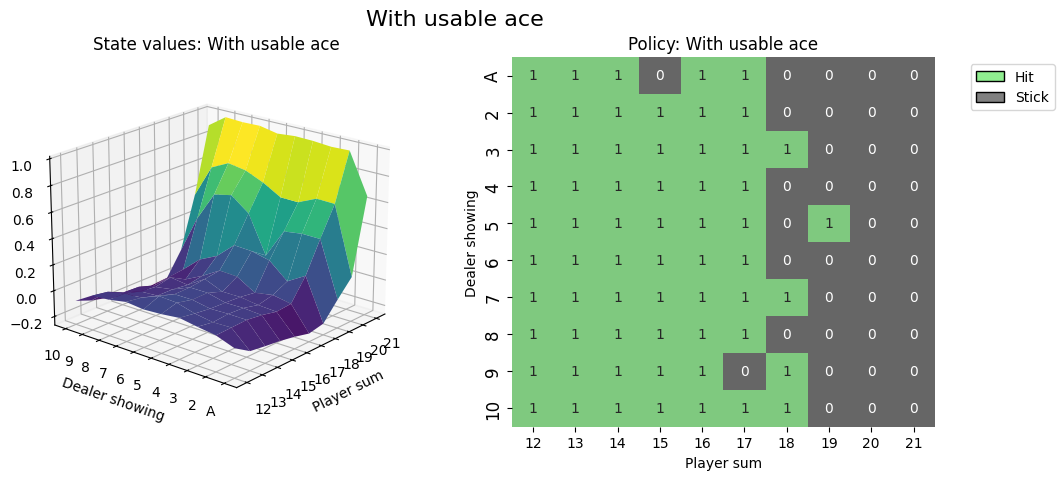

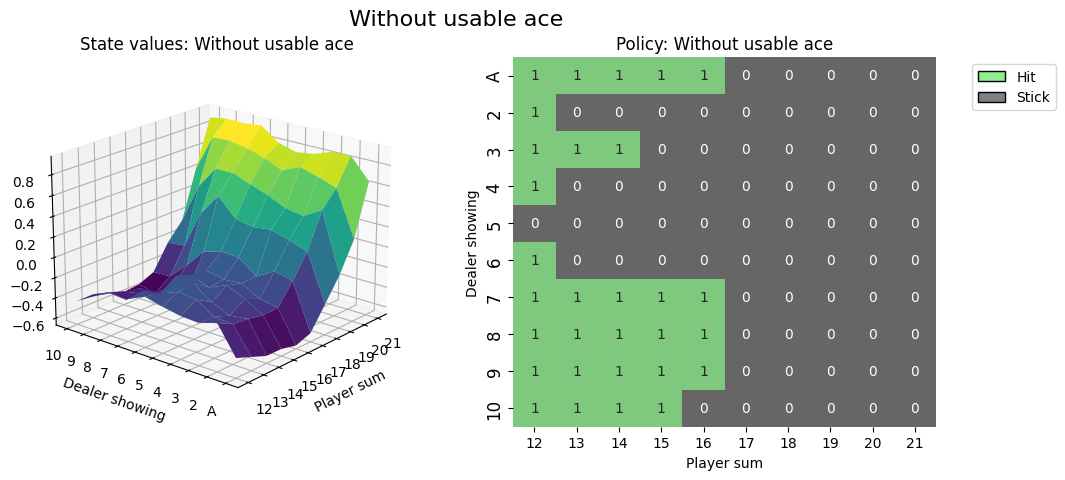

In [30]:
visualise_strategy(q_learning_agent)

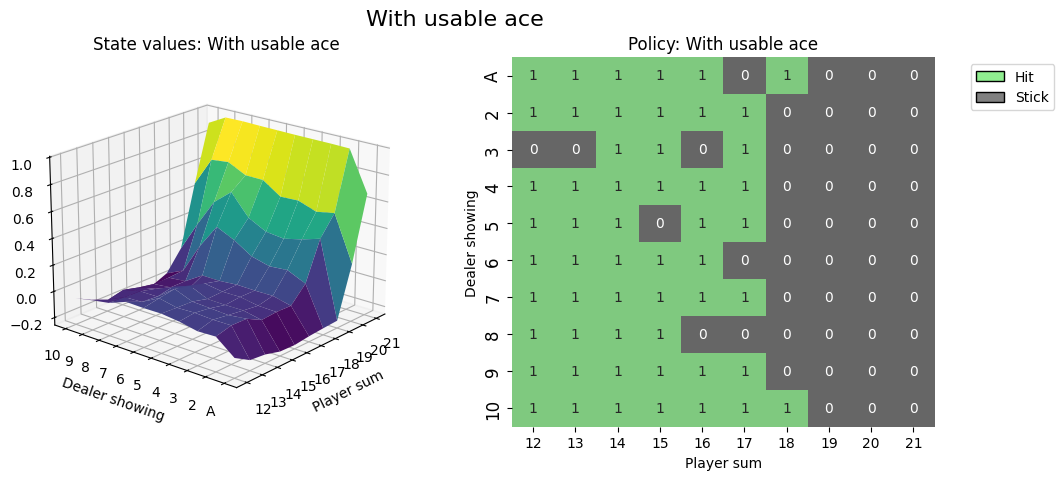

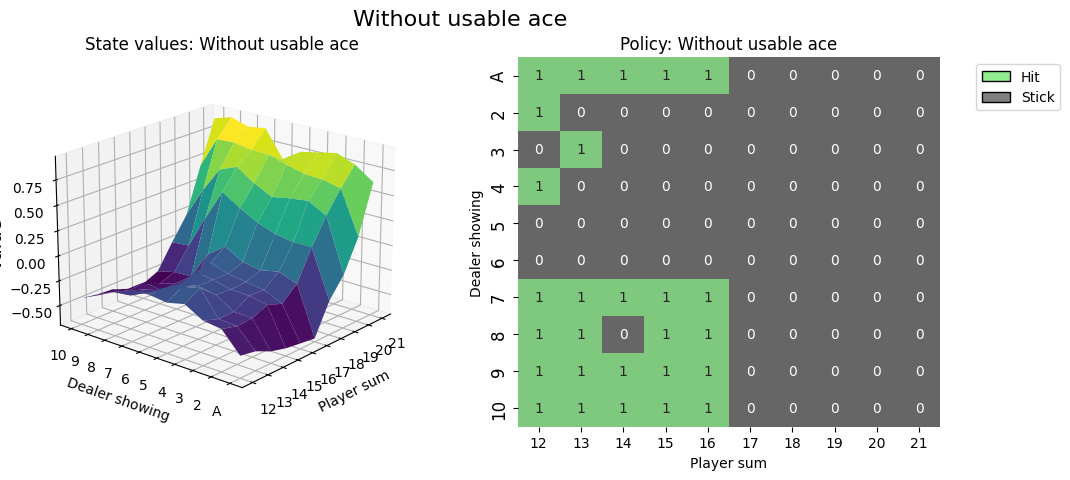

In [31]:
visualise_strategy(sarsa_agent)

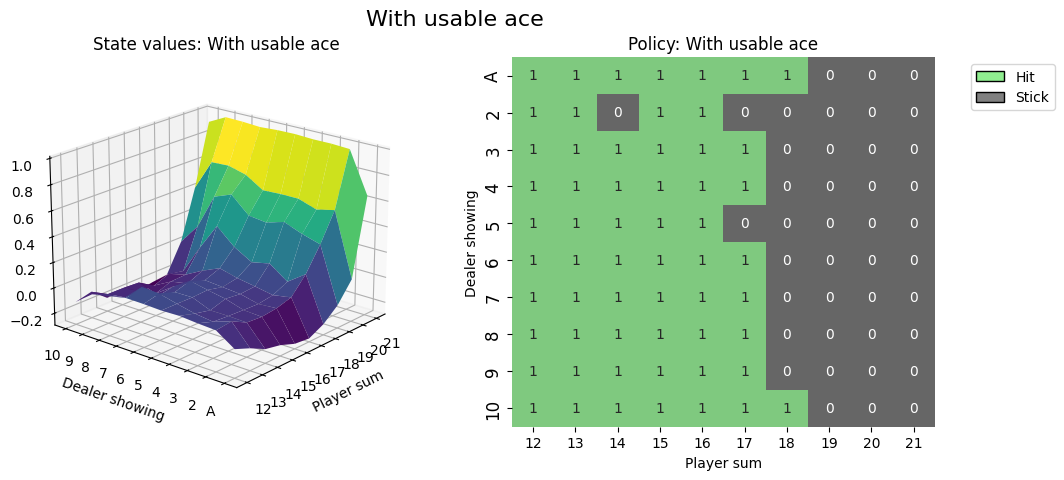

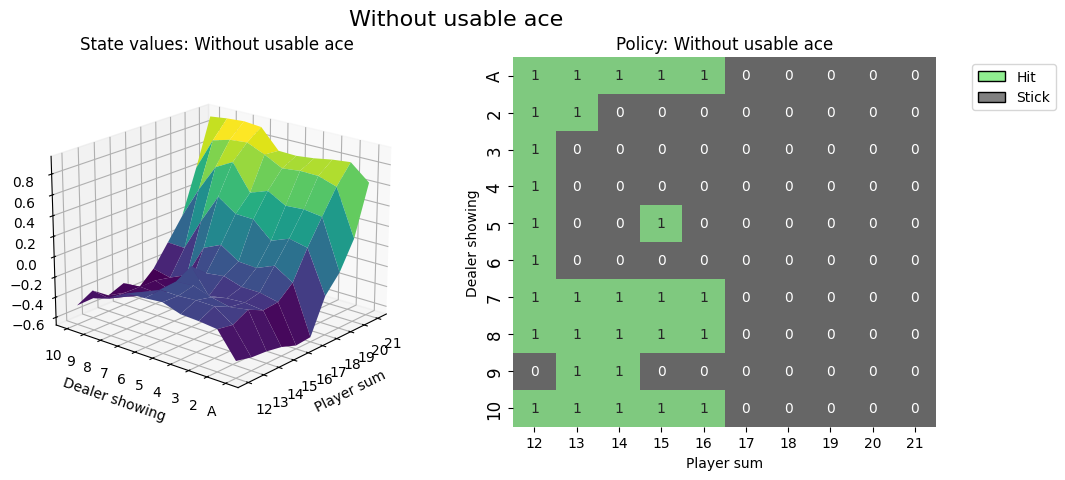

In [32]:
visualise_strategy(expected_sarsa_agent)

In [51]:
results

,win,draw,lose
model,,,
Q-learning,0.421,0.080,0.499
SARSA(0.9),0.414,0.102,0.484
EV-SARSA(0.9),0.426,0.084,0.490


Интуитивно кажется, что SARSA и EV-SARSA должны меньше хитать в ситуациях со средним скором с тузом, так как они учитывают, что при маленькой карте может выпасть случайное действие (в том числе stay) и не получится усилить руку. На практике SARSA действительно хитает меньше, а вот на EV-SARSA эта логика почему-то не распростроняется.

Также можно заметить нелогичные действия, например SARSA не хитает 14 vs 2, хотя хитает соседние. EV-SARSA хитает 15 vs 5, при том, что не хитает ничего в округе. Это говорит о том, что алгоритмы скорее всего не успели сойтись.

В этой игре есть очевидные споты и гранчные, в которые не совссем понятно, что делать. Возможно хорошим дополнением к EV-SARSA и Q-learning, как к off-policy алгоритмам, было бы добавить priority replay buffer, который помог бы проучить сложные споты.

### Compare the agents' strategies and evaluation performance with $\lambda = 0$ (Q-learning vs Sarsa(0) vs EVSarsa(0)). Why don't we use N-step targets or eligibility traces for Q-learning?

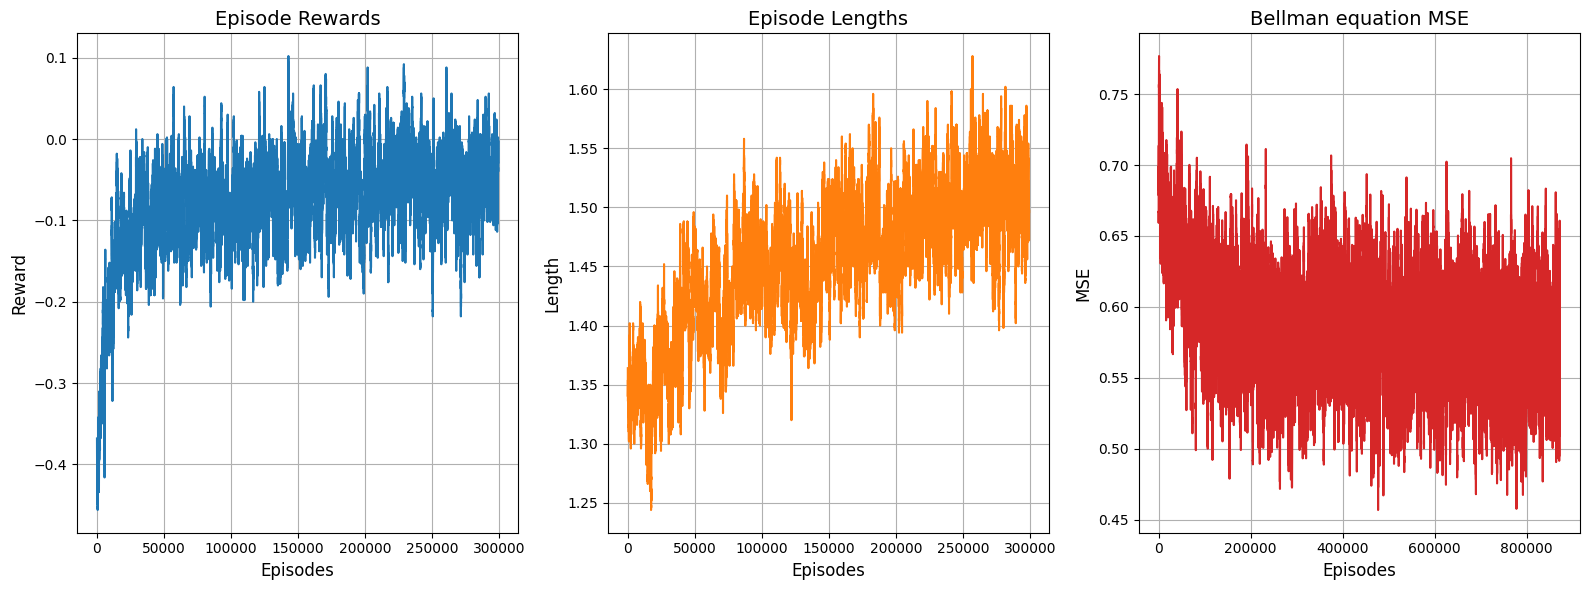

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [01:10<00:00, 4246.91it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [52]:
env = gym.make("Blackjack-v1", sab=True)

expected_sarsa_agent = EVSarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0,
)

train_agent(expected_sarsa_agent, env, n_episodes, epsilon_decay=0.9)

In [54]:
env = gym.make("Blackjack-v1", sab=True)

results.loc['EV-SARSA(0)'] = evaluate_agent(env, expected_sarsa_agent).values()
results

Episode 99: Win 41, Draw 11, Lose 48
Episode 199: Win 79, Draw 24, Lose 97
Episode 299: Win 114, Draw 36, Lose 150
Episode 399: Win 152, Draw 40, Lose 208
Episode 499: Win 188, Draw 49, Lose 263
Episode 599: Win 233, Draw 59, Lose 308
Episode 699: Win 281, Draw 66, Lose 353
Episode 799: Win 327, Draw 75, Lose 398
Episode 899: Win 375, Draw 85, Lose 440
Episode 999: Win 419, Draw 90, Lose 491


,win,draw,lose
model,,,
Q-learning,0.421,0.080,0.499
SARSA(0.9),0.414,0.102,0.484
EV-SARSA(0.9),0.426,0.084,0.490
EV-SARSA(0),0.419,0.090,0.491


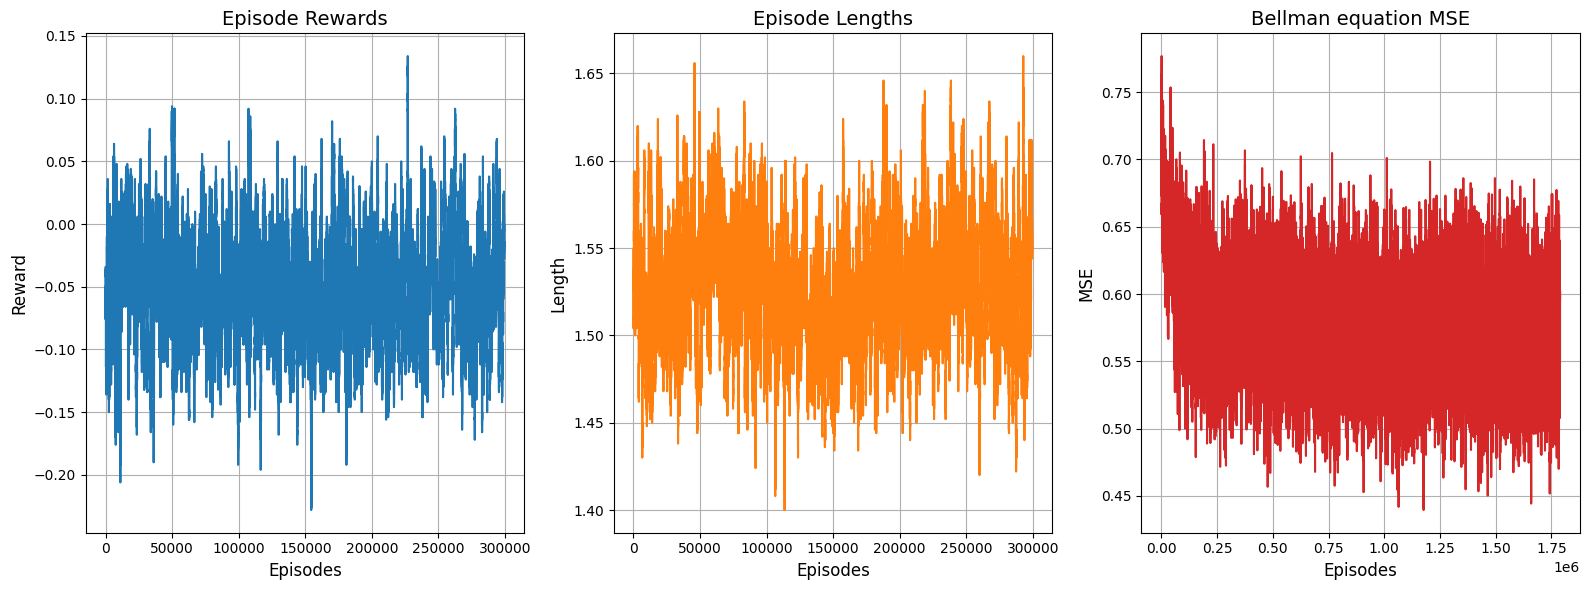

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [01:28<00:00, 3397.09it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [53]:
env = gym.make("Blackjack-v1", sab=True)

sarsa_agent = SarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0,
)

train_agent(expected_sarsa_agent, env, n_episodes, epsilon_decay=0.9)

In [55]:
env = gym.make("Blackjack-v1", sab=True)

results.loc['SARSA(0)'] = evaluate_agent(env, sarsa_agent).values()
results

Episode 99: Win 32, Draw 6, Lose 62
Episode 199: Win 69, Draw 17, Lose 114
Episode 299: Win 116, Draw 22, Lose 162
Episode 399: Win 158, Draw 28, Lose 214
Episode 499: Win 197, Draw 33, Lose 270
Episode 599: Win 250, Draw 36, Lose 314
Episode 699: Win 285, Draw 46, Lose 369
Episode 799: Win 324, Draw 52, Lose 424
Episode 899: Win 374, Draw 56, Lose 470
Episode 999: Win 419, Draw 60, Lose 521


,win,draw,lose
model,,,
Q-learning,0.421,0.080,0.499
SARSA(0.9),0.414,0.102,0.484
EV-SARSA(0.9),0.426,0.084,0.490
EV-SARSA(0),0.419,0.090,0.491
SARSA(0),0.419,0.060,0.521


SARSA без eligibility traces страдает больше всего, я думаю, что ей просто не хватает итераций, так как она использует стохастическую оценку одним сжмплом вместо матожидания, из-за этого очень сильно шумят value функции и обучение не сходится.

#### Why don't we use N-step targets or eligibility traces for Q-learning?

В целом можно использовать N-step Q-learning. 

### Compare Sarsa($\lambda$) for different $\lambda$ values.

In [19]:
lambdas = [0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 0.95, 1.0]
len(lambdas)

9

In [20]:
sarsa_results = pd.DataFrame({'lambda': [], 'win': [], 'draw': [], 'lose': []}).set_index('lambda')
sarsa_results

,win,draw,lose
lambda,,,


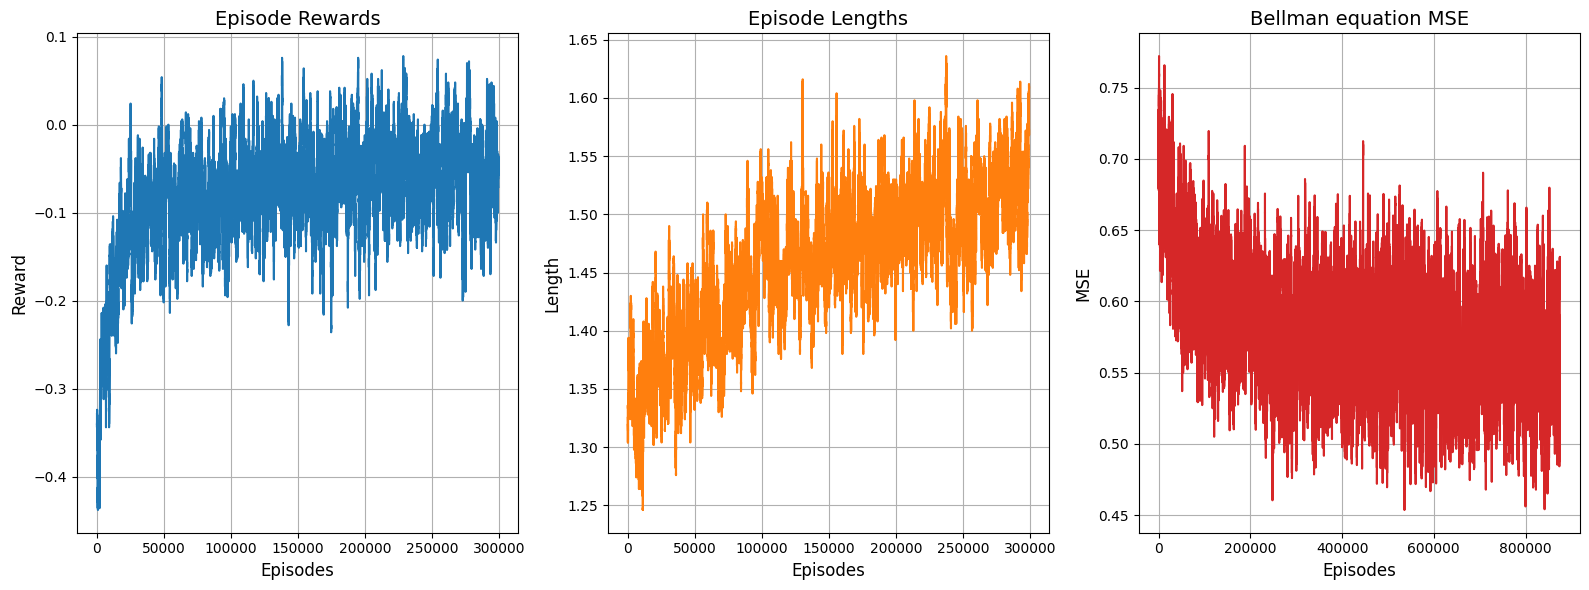

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [09:59<00:00, 66.63s/it]

Episode 99: Win 38, Draw 14, Lose 48
Episode 199: Win 73, Draw 23, Lose 104
Episode 299: Win 121, Draw 30, Lose 149
Episode 399: Win 164, Draw 43, Lose 193
Episode 499: Win 209, Draw 54, Lose 237
Episode 599: Win 261, Draw 61, Lose 278
Episode 699: Win 293, Draw 67, Lose 340
Episode 799: Win 344, Draw 73, Lose 383
Episode 899: Win 382, Draw 82, Lose 436
Episode 999: Win 423, Draw 95, Lose 482


In [23]:
for l in tqdm(lambdas):
    env = gym.make("Blackjack-v1", sab=True)
    
    n_episodes = 300_000
    learning_rate = 4e-3
    n_actions = env.action_space.n
    epsilon = 1.0

    sarsa_temp_agent = SarsaAgent(
        n_actions=env.action_space.n,
        learning_rate=learning_rate,
        epsilon=epsilon,
        decay_factor=l,
    )
    train_agent(sarsa_temp_agent, env, n_episodes, epsilon_decay=0.9)
    env = gym.make("Blackjack-v1", sab=True)
    sarsa_results.loc[str(l)] = evaluate_agent(env, sarsa_temp_agent).values()

In [26]:
sarsa_results['EV'] = sarsa_results['win'] - sarsa_results['lose']

In [27]:
sarsa_results

,win,draw,lose,EV
lambda,,,,
0.1,0.409,0.095,0.496,-0.087
0.2,0.423,0.085,0.492,-0.069
0.35,0.415,0.091,0.494,-0.079
0.5,0.417,0.087,0.496,-0.079
0.65,0.430,0.085,0.485,-0.055
0.8,0.396,0.092,0.512,-0.116
0.9,0.461,0.078,0.461,0.000
0.95,0.417,0.084,0.499,-0.082
1.0,0.423,0.095,0.482,-0.059


Видимо оценки немного шумят, но если бы не было выброса в 0.8, прослеживался бы тренд вверх по качеству модели. Я бы поставил, что большее преимущество eligibility traces даже может быть в скорости сходимости, чем в итоговом качестве.